In [90]:
import sys
print(sys.version)


3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ]


# importing modules

In [91]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


# initialisation of parameters

In [92]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 600    # Size of the train dataset
n_test = 50     # Size of the test dataset

SAVE_PATH = "./"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator


# dataset loading

In [93]:
mnist_dataset = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [94]:
train_images.shape

(600, 28, 28, 1)

# Circuit creation

## 4*4 kernel size

In [120]:
### 4*4 kernel size rand_params
rand_params4

array([[3.72495259, 5.30467815, 5.3906313 , 5.32343968, 3.91796626,
        2.4151415 , 1.86946507, 0.35633815, 1.71315002, 3.00125845,
        5.10300662, 3.01578552, 2.46793966, 5.2532378 , 2.1199226 ,
        4.07258398]])

In [119]:
kernel_size = 16
dev = qml.device("default.qubit", wires=kernel_size)
# Random circuit parameters
rand_params4 = np.random.uniform(high=2 * np.pi, size=(n_layers, kernel_size))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(kernel_size):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params4, wires=list(range(kernel_size)))

    # Measurement producing 16 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size)]

# 3*3 kernel size

In [112]:
rand_params3

array([[3.72495259, 5.30467815, 5.3906313 , 5.32343968, 3.91796626,
        2.4151415 , 1.86946507, 0.35633815, 1.71315002]])

In [111]:

kernel_size = 9
dev = qml.device("default.qubit", wires=kernel_size)
# Random circuit parameters
rand_params3 = np.random.uniform(high=2 * np.pi, size=(n_layers, kernel_size))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 9 classical input values
    for j in range(kernel_size):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params3, wires=list(range(kernel_size)))

    # Measurement producing 9 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(kernel_size)]

# 2*2 kernel size

In [103]:
rand_params2

tensor([[0.84960084, 2.03663802, 0.94043493, 1.39688648]], requires_grad=True)

In [102]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params2 = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params2, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

# Quantum Convolution

# 4*4 kernel

In [121]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    output_size = 7  # since 28 / 4 = 7
    out = np.zeros((output_size, output_size, 16))  # output array has 16 channels now

    # Loop over the coordinates of the top-left pixel of 4x4 squares
    for j in range(0, 28, 4):
        for k in range(0, 28, 4):
            # Process a squared 4x4 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k], image[j, k+1], image[j, k+2], image[j, k+3],
                    image[j+1, k], image[j+1, k+1], image[j+1, k+2], image[j+1, k+3],
                    image[j+2, k], image[j+2, k+1], image[j+2, k+2], image[j+2, k+3],
                    image[j+3, k], image[j+3, k+1], image[j+3, k+2], image[j+3, k+3]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/4, k/4)
            for c in range(16):
                out[j // 4, k // 4, c] = q_results[c]
    return out


# 3*3 kernel

In [113]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    output_size = 9  # since 28 / 3 ≈ 9
    out = np.zeros((output_size, output_size, 9))  # output array has 9 channels now

    # Loop over the coordinates of the top-left pixel of 3X3 squares
    for j in range(0, 26, 3):
        for k in range(0, 26, 3):
            # Process a squared 3x3 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k], image[j, k+1], image[j, k+2],
                    image[j+1, k], image[j+1, k+1], image[j+1, k+2],
                    image[j+2, k], image[j+2, k+1], image[j+2, k+2]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(9):
                out[j // 3, k // 3, c] = q_results[c]
    return out

# 2*2 kernel

In [104]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# Quantum pre-processing

In [122]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
600/600        
Quantum pre-processing of test images:


# Seeing sample images from dataset

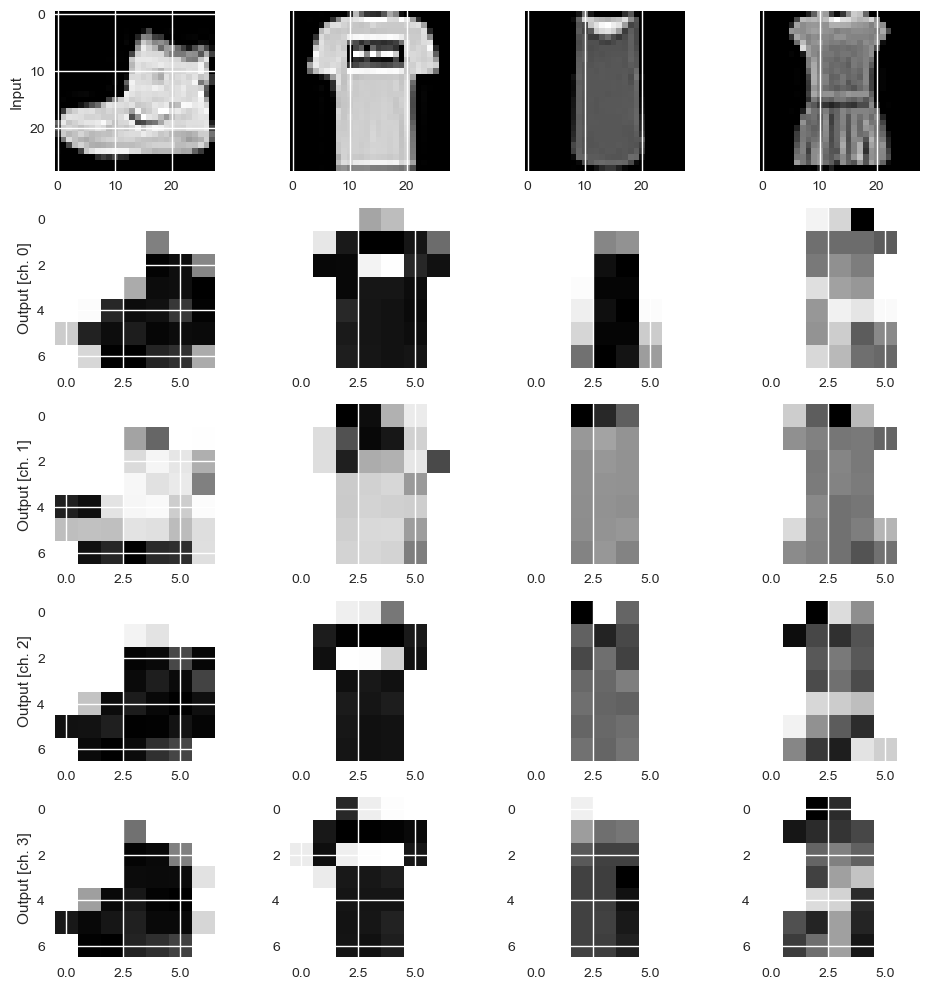

In [123]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

# Neural Network with quantum convolution 

In [124]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the MyModel function
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Function to train the model and return the val_accuracy and val_loss history
def train_and_evaluate():
    # Set seeds for reproducibility
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Initialize and compile the model
    q_model = MyModel()
    
    # Fit the model
    q_history = q_model.fit(
        q_train_images,
        train_labels,
        validation_data=(q_test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
        shuffle=False  # Disable shuffling for consistency
    )
    
    # Return the val_accuracy and val_loss history
    return q_history.history['val_accuracy'], q_history.history['val_loss']

# Number of runs
num_runs = 20
val_accuracies_all = []
val_losses_all = []

# Run the training process multiple times and collect val_accuracy and val_loss histories
for i in range(num_runs):
    val_accuracies, val_losses = train_and_evaluate()
    val_accuracies_all.append(val_accuracies)
    val_losses_all.append(val_losses)
    print(f"Run {i + 1} completed")

# Convert lists to numpy arrays for easier averaging
val_accuracies_all = np.array(val_accuracies_all)
val_losses_all = np.array(val_losses_all)

# Calculate the average val_accuracy and val_loss for each epoch
average_val_accuracies = np.mean(val_accuracies_all, axis=0)
average_val_losses = np.mean(val_losses_all, axis=0)


Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5467 - loss: 1.3474 - val_accuracy: 0.7400 - val_loss: 0.8406
Epoch 2/30
150/150 - 0s - 401us/step - accuracy: 0.7550 - loss: 0.7404 - val_accuracy: 0.7600 - val_loss: 0.7591
Epoch 3/30
150/150 - 0s - 393us/step - accuracy: 0.8250 - loss: 0.5889 - val_accuracy: 0.7800 - val_loss: 0.7366
Epoch 4/30
150/150 - 0s - 385us/step - accuracy: 0.8500 - loss: 0.4949 - val_accuracy: 0.7600 - val_loss: 0.7293
Epoch 5/30
150/150 - 0s - 396us/step - accuracy: 0.8733 - loss: 0.4254 - val_accuracy: 0.7400 - val_loss: 0.7267
Epoch 6/30
150/150 - 0s - 404us/step - accuracy: 0.8983 - loss: 0.3701 - val_accuracy: 0.7400 - val_loss: 0.7264
Epoch 7/30
150/150 - 0s - 386us/step - accuracy: 0.9083 - loss: 0.3248 - val_accuracy: 0.7600 - val_loss: 0.7291
Epoch 8/30
150/150 - 0s - 375us/step - accuracy: 0.9167 - loss: 0.2872 - val_accuracy: 0.7400 - val_loss: 0.7351
Epoch 9/30
150/150 - 0s - 371us/step - accuracy: 0.9367 - loss: 0.2557 - val_accuracy: 0.7600 - va

Epoch 13/30
150/150 - 0s - 382us/step - accuracy: 0.9667 - loss: 0.1722 - val_accuracy: 0.7000 - val_loss: 0.8714
Epoch 14/30
150/150 - 0s - 364us/step - accuracy: 0.9700 - loss: 0.1570 - val_accuracy: 0.7000 - val_loss: 0.8839
Epoch 15/30
150/150 - 0s - 364us/step - accuracy: 0.9733 - loss: 0.1437 - val_accuracy: 0.7000 - val_loss: 0.8964
Epoch 16/30
150/150 - 0s - 372us/step - accuracy: 0.9750 - loss: 0.1320 - val_accuracy: 0.6800 - val_loss: 0.9087
Epoch 17/30
150/150 - 0s - 363us/step - accuracy: 0.9833 - loss: 0.1217 - val_accuracy: 0.6800 - val_loss: 0.9203
Epoch 18/30
150/150 - 0s - 367us/step - accuracy: 0.9850 - loss: 0.1125 - val_accuracy: 0.6800 - val_loss: 0.9313
Epoch 19/30
150/150 - 0s - 357us/step - accuracy: 0.9867 - loss: 0.1042 - val_accuracy: 0.6800 - val_loss: 0.9414
Epoch 20/30
150/150 - 0s - 357us/step - accuracy: 0.9883 - loss: 0.0967 - val_accuracy: 0.6800 - val_loss: 0.9507
Epoch 21/30
150/150 - 0s - 351us/step - accuracy: 0.9900 - loss: 0.0898 - val_accuracy: 

Epoch 25/30
150/150 - 0s - 368us/step - accuracy: 0.9950 - loss: 0.0691 - val_accuracy: 0.6600 - val_loss: 1.0064
Epoch 26/30
150/150 - 0s - 360us/step - accuracy: 0.9950 - loss: 0.0645 - val_accuracy: 0.6600 - val_loss: 1.0114
Epoch 27/30
150/150 - 0s - 639us/step - accuracy: 0.9983 - loss: 0.0603 - val_accuracy: 0.6600 - val_loss: 1.0159
Epoch 28/30
150/150 - 0s - 388us/step - accuracy: 0.9983 - loss: 0.0564 - val_accuracy: 0.6600 - val_loss: 1.0198
Epoch 29/30
150/150 - 0s - 359us/step - accuracy: 0.9983 - loss: 0.0527 - val_accuracy: 0.6600 - val_loss: 1.0233
Epoch 30/30
150/150 - 0s - 363us/step - accuracy: 0.9983 - loss: 0.0493 - val_accuracy: 0.6600 - val_loss: 1.0264
Run 5 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5533 - loss: 1.3657 - val_accuracy: 0.6800 - val_loss: 0.8865
Epoch 2/30
150/150 - 0s - 365us/step - accuracy: 0.7550 - loss: 0.7534 - val_accuracy: 0.8000 - val_loss: 0.7968
Epoch 3/30
150/150 - 0s - 369us/step - accuracy: 0.8183 - loss: 0.5983 - val

Epoch 7/30
150/150 - 0s - 371us/step - accuracy: 0.9017 - loss: 0.3315 - val_accuracy: 0.7600 - val_loss: 0.7635
Epoch 8/30
150/150 - 0s - 369us/step - accuracy: 0.9183 - loss: 0.2936 - val_accuracy: 0.7600 - val_loss: 0.7686
Epoch 9/30
150/150 - 0s - 374us/step - accuracy: 0.9300 - loss: 0.2616 - val_accuracy: 0.7400 - val_loss: 0.7776
Epoch 10/30
150/150 - 0s - 376us/step - accuracy: 0.9383 - loss: 0.2343 - val_accuracy: 0.7400 - val_loss: 0.7895
Epoch 11/30
150/150 - 0s - 368us/step - accuracy: 0.9517 - loss: 0.2109 - val_accuracy: 0.7400 - val_loss: 0.8030
Epoch 12/30
150/150 - 0s - 386us/step - accuracy: 0.9617 - loss: 0.1907 - val_accuracy: 0.7200 - val_loss: 0.8172
Epoch 13/30
150/150 - 0s - 386us/step - accuracy: 0.9683 - loss: 0.1731 - val_accuracy: 0.7200 - val_loss: 0.8314
Epoch 14/30
150/150 - 0s - 370us/step - accuracy: 0.9733 - loss: 0.1578 - val_accuracy: 0.7200 - val_loss: 0.8453
Epoch 15/30
150/150 - 0s - 361us/step - accuracy: 0.9733 - loss: 0.1443 - val_accuracy: 0.7

Epoch 19/30
150/150 - 0s - 364us/step - accuracy: 0.9867 - loss: 0.1021 - val_accuracy: 0.7000 - val_loss: 0.8595
Epoch 20/30
150/150 - 0s - 375us/step - accuracy: 0.9883 - loss: 0.0947 - val_accuracy: 0.7000 - val_loss: 0.8708
Epoch 21/30
150/150 - 0s - 370us/step - accuracy: 0.9900 - loss: 0.0880 - val_accuracy: 0.7000 - val_loss: 0.8810
Epoch 22/30
150/150 - 0s - 367us/step - accuracy: 0.9917 - loss: 0.0819 - val_accuracy: 0.7000 - val_loss: 0.8903
Epoch 23/30
150/150 - 0s - 372us/step - accuracy: 0.9933 - loss: 0.0763 - val_accuracy: 0.7000 - val_loss: 0.8986
Epoch 24/30
150/150 - 0s - 367us/step - accuracy: 0.9950 - loss: 0.0712 - val_accuracy: 0.7000 - val_loss: 0.9061
Epoch 25/30
150/150 - 0s - 369us/step - accuracy: 0.9967 - loss: 0.0665 - val_accuracy: 0.7000 - val_loss: 0.9128
Epoch 26/30
150/150 - 0s - 380us/step - accuracy: 0.9983 - loss: 0.0621 - val_accuracy: 0.7000 - val_loss: 0.9188
Epoch 27/30
150/150 - 0s - 374us/step - accuracy: 0.9983 - loss: 0.0581 - val_accuracy: 

Run 12 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5733 - loss: 1.2744 - val_accuracy: 0.7000 - val_loss: 0.9091
Epoch 2/30
150/150 - 0s - 379us/step - accuracy: 0.7483 - loss: 0.7397 - val_accuracy: 0.7400 - val_loss: 0.8263
Epoch 3/30
150/150 - 0s - 382us/step - accuracy: 0.8067 - loss: 0.5897 - val_accuracy: 0.7800 - val_loss: 0.7951
Epoch 4/30
150/150 - 0s - 393us/step - accuracy: 0.8467 - loss: 0.4948 - val_accuracy: 0.7800 - val_loss: 0.7782
Epoch 5/30
150/150 - 0s - 501us/step - accuracy: 0.8667 - loss: 0.4252 - val_accuracy: 0.7600 - val_loss: 0.7685
Epoch 6/30
150/150 - 0s - 511us/step - accuracy: 0.8867 - loss: 0.3705 - val_accuracy: 0.7400 - val_loss: 0.7636
Epoch 7/30
150/150 - 0s - 444us/step - accuracy: 0.9033 - loss: 0.3259 - val_accuracy: 0.7400 - val_loss: 0.7638
Epoch 8/30
150/150 - 0s - 413us/step - accuracy: 0.9217 - loss: 0.2887 - val_accuracy: 0.7200 - val_loss: 0.7690
Epoch 9/30
150/150 - 0s - 395us/step - accuracy: 0.9350 - loss: 0.2571 - val_accu

Epoch 13/30
150/150 - 0s - 358us/step - accuracy: 0.9700 - loss: 0.1703 - val_accuracy: 0.6800 - val_loss: 0.8480
Epoch 14/30
150/150 - 0s - 361us/step - accuracy: 0.9750 - loss: 0.1551 - val_accuracy: 0.6800 - val_loss: 0.8604
Epoch 15/30
150/150 - 0s - 361us/step - accuracy: 0.9767 - loss: 0.1417 - val_accuracy: 0.6800 - val_loss: 0.8725
Epoch 16/30
150/150 - 0s - 401us/step - accuracy: 0.9783 - loss: 0.1299 - val_accuracy: 0.6800 - val_loss: 0.8841
Epoch 17/30
150/150 - 0s - 364us/step - accuracy: 0.9817 - loss: 0.1195 - val_accuracy: 0.6600 - val_loss: 0.8950
Epoch 18/30
150/150 - 0s - 359us/step - accuracy: 0.9817 - loss: 0.1103 - val_accuracy: 0.6600 - val_loss: 0.9052
Epoch 19/30
150/150 - 0s - 355us/step - accuracy: 0.9850 - loss: 0.1020 - val_accuracy: 0.6600 - val_loss: 0.9146
Epoch 20/30
150/150 - 0s - 357us/step - accuracy: 0.9883 - loss: 0.0945 - val_accuracy: 0.6600 - val_loss: 0.9232
Epoch 21/30
150/150 - 0s - 368us/step - accuracy: 0.9917 - loss: 0.0877 - val_accuracy: 

Epoch 25/30
150/150 - 0s - 401us/step - accuracy: 0.9950 - loss: 0.0669 - val_accuracy: 0.6800 - val_loss: 0.9757
Epoch 26/30
150/150 - 0s - 430us/step - accuracy: 0.9983 - loss: 0.0625 - val_accuracy: 0.6800 - val_loss: 0.9815
Epoch 27/30
150/150 - 0s - 376us/step - accuracy: 0.9983 - loss: 0.0584 - val_accuracy: 0.6800 - val_loss: 0.9866
Epoch 28/30
150/150 - 0s - 378us/step - accuracy: 0.9983 - loss: 0.0547 - val_accuracy: 0.6800 - val_loss: 0.9912
Epoch 29/30
150/150 - 0s - 362us/step - accuracy: 0.9983 - loss: 0.0512 - val_accuracy: 0.6800 - val_loss: 0.9953
Epoch 30/30
150/150 - 0s - 376us/step - accuracy: 0.9983 - loss: 0.0479 - val_accuracy: 0.6800 - val_loss: 0.9990
Run 17 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5067 - loss: 1.4441 - val_accuracy: 0.6800 - val_loss: 0.9146
Epoch 2/30
150/150 - 0s - 388us/step - accuracy: 0.7467 - loss: 0.7603 - val_accuracy: 0.7400 - val_loss: 0.8146
Epoch 3/30
150/150 - 0s - 370us/step - accuracy: 0.8167 - loss: 0.6037 - va

Epoch 7/30
150/150 - 0s - 391us/step - accuracy: 0.9033 - loss: 0.3254 - val_accuracy: 0.7400 - val_loss: 0.7934
Epoch 8/30
150/150 - 0s - 375us/step - accuracy: 0.9150 - loss: 0.2885 - val_accuracy: 0.7600 - val_loss: 0.7981
Epoch 9/30
150/150 - 0s - 378us/step - accuracy: 0.9300 - loss: 0.2570 - val_accuracy: 0.7400 - val_loss: 0.8057
Epoch 10/30
150/150 - 0s - 372us/step - accuracy: 0.9433 - loss: 0.2300 - val_accuracy: 0.7200 - val_loss: 0.8155
Epoch 11/30
150/150 - 0s - 366us/step - accuracy: 0.9600 - loss: 0.2068 - val_accuracy: 0.7200 - val_loss: 0.8269
Epoch 12/30
150/150 - 0s - 400us/step - accuracy: 0.9667 - loss: 0.1868 - val_accuracy: 0.7200 - val_loss: 0.8393
Epoch 13/30
150/150 - 0s - 403us/step - accuracy: 0.9717 - loss: 0.1696 - val_accuracy: 0.7200 - val_loss: 0.8522
Epoch 14/30
150/150 - 0s - 405us/step - accuracy: 0.9733 - loss: 0.1546 - val_accuracy: 0.7200 - val_loss: 0.8653
Epoch 15/30
150/150 - 0s - 377us/step - accuracy: 0.9733 - loss: 0.1415 - val_accuracy: 0.7

# Normal Convolution Neural Network

In [108]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define the MyModel function
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Function to train the model and return the val_accuracy and val_loss history
def train_and_evaluate():
    # Set seeds for reproducibility
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Initialize and compile the model
    c_model = MyModel()
    
    # Fit the model
    c_history = c_model.fit(
        train_images,
        train_labels,
        validation_data=(test_images, test_labels),
        batch_size=4,
        epochs=n_epochs,
        verbose=2,
        shuffle=False  # Disable shuffling for consistency
    )
    
    # Return the val_accuracy and val_loss history
    return c_history.history['val_accuracy'], c_history.history['val_loss']

# Number of runs
num_runs = 20
val_accuracies_all = []
val_losses_all = []

# Run the training process multiple times and collect val_accuracy and val_loss histories
for i in range(num_runs):
    val_accuracies, val_losses = train_and_evaluate()
    val_accuracies_all.append(val_accuracies)
    val_losses_all.append(val_losses)
    print(f"Run {i + 1} completed")

# Convert lists to numpy arrays for easier averaging
val_accuracies_all = np.array(val_accuracies_all)
val_losses_all = np.array(val_losses_all)

# Calculate the average val_accuracy and val_loss for each epoch
average_val_accuracies_c = np.mean(val_accuracies_all, axis=0)
average_val_losses_c = np.mean(val_losses_all, axis=0)


Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5217 - loss: 1.4529 - val_accuracy: 0.7400 - val_loss: 0.9789
Epoch 2/30
150/150 - 0s - 413us/step - accuracy: 0.7217 - loss: 0.8979 - val_accuracy: 0.7200 - val_loss: 0.8519
Epoch 3/30
150/150 - 0s - 422us/step - accuracy: 0.7733 - loss: 0.7518 - val_accuracy: 0.7000 - val_loss: 0.7960
Epoch 4/30
150/150 - 0s - 417us/step - accuracy: 0.7950 - loss: 0.6645 - val_accuracy: 0.7000 - val_loss: 0.7610
Epoch 5/30
150/150 - 0s - 415us/step - accuracy: 0.8167 - loss: 0.6005 - val_accuracy: 0.6800 - val_loss: 0.7368
Epoch 6/30
150/150 - 0s - 430us/step - accuracy: 0.8433 - loss: 0.5497 - val_accuracy: 0.6600 - val_loss: 0.7194
Epoch 7/30
150/150 - 0s - 425us/step - accuracy: 0.8600 - loss: 0.5077 - val_accuracy: 0.7000 - val_loss: 0.7064
Epoch 8/30
150/150 - 0s - 419us/step - accuracy: 0.8700 - loss: 0.4722 - val_accuracy: 0.7000 - val_loss: 0.6962
Epoch 9/30
150/150 - 0s - 419us/step - accuracy: 0.8750 - loss: 0.4416 - val_accuracy: 0.6800 - va

Epoch 13/30
150/150 - 0s - 419us/step - accuracy: 0.9067 - loss: 0.3408 - val_accuracy: 0.7200 - val_loss: 0.6813
Epoch 14/30
150/150 - 0s - 406us/step - accuracy: 0.9150 - loss: 0.3234 - val_accuracy: 0.7200 - val_loss: 0.6766
Epoch 15/30
150/150 - 0s - 406us/step - accuracy: 0.9217 - loss: 0.3073 - val_accuracy: 0.7000 - val_loss: 0.6726
Epoch 16/30
150/150 - 0s - 412us/step - accuracy: 0.9317 - loss: 0.2925 - val_accuracy: 0.7000 - val_loss: 0.6693
Epoch 17/30
150/150 - 0s - 407us/step - accuracy: 0.9367 - loss: 0.2786 - val_accuracy: 0.7000 - val_loss: 0.6664
Epoch 18/30
150/150 - 0s - 400us/step - accuracy: 0.9400 - loss: 0.2657 - val_accuracy: 0.6800 - val_loss: 0.6640
Epoch 19/30
150/150 - 0s - 398us/step - accuracy: 0.9417 - loss: 0.2536 - val_accuracy: 0.6800 - val_loss: 0.6620
Epoch 20/30
150/150 - 0s - 409us/step - accuracy: 0.9433 - loss: 0.2422 - val_accuracy: 0.6800 - val_loss: 0.6604
Epoch 21/30
150/150 - 0s - 435us/step - accuracy: 0.9450 - loss: 0.2316 - val_accuracy: 

Epoch 25/30
150/150 - 0s - 426us/step - accuracy: 0.9617 - loss: 0.1971 - val_accuracy: 0.6600 - val_loss: 0.6511
Epoch 26/30
150/150 - 0s - 413us/step - accuracy: 0.9633 - loss: 0.1894 - val_accuracy: 0.6600 - val_loss: 0.6516
Epoch 27/30
150/150 - 0s - 410us/step - accuracy: 0.9633 - loss: 0.1821 - val_accuracy: 0.6600 - val_loss: 0.6524
Epoch 28/30
150/150 - 0s - 402us/step - accuracy: 0.9683 - loss: 0.1752 - val_accuracy: 0.6600 - val_loss: 0.6533
Epoch 29/30
150/150 - 0s - 397us/step - accuracy: 0.9717 - loss: 0.1687 - val_accuracy: 0.6600 - val_loss: 0.6543
Epoch 30/30
150/150 - 0s - 410us/step - accuracy: 0.9717 - loss: 0.1626 - val_accuracy: 0.6600 - val_loss: 0.6556
Run 5 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5267 - loss: 1.4313 - val_accuracy: 0.6200 - val_loss: 1.0279
Epoch 2/30
150/150 - 0s - 408us/step - accuracy: 0.7217 - loss: 0.8866 - val_accuracy: 0.6200 - val_loss: 0.8956
Epoch 3/30
150/150 - 0s - 405us/step - accuracy: 0.7683 - loss: 0.7404 - val

Epoch 7/30
150/150 - 0s - 404us/step - accuracy: 0.8583 - loss: 0.4987 - val_accuracy: 0.6600 - val_loss: 0.7270
Epoch 8/30
150/150 - 0s - 413us/step - accuracy: 0.8683 - loss: 0.4635 - val_accuracy: 0.6600 - val_loss: 0.7174
Epoch 9/30
150/150 - 0s - 413us/step - accuracy: 0.8783 - loss: 0.4332 - val_accuracy: 0.6600 - val_loss: 0.7095
Epoch 10/30
150/150 - 0s - 404us/step - accuracy: 0.8817 - loss: 0.4068 - val_accuracy: 0.6600 - val_loss: 0.7026
Epoch 11/30
150/150 - 0s - 406us/step - accuracy: 0.8917 - loss: 0.3833 - val_accuracy: 0.6600 - val_loss: 0.6967
Epoch 12/30
150/150 - 0s - 430us/step - accuracy: 0.9000 - loss: 0.3623 - val_accuracy: 0.6600 - val_loss: 0.6917
Epoch 13/30
150/150 - 0s - 431us/step - accuracy: 0.9083 - loss: 0.3432 - val_accuracy: 0.6800 - val_loss: 0.6874
Epoch 14/30
150/150 - 0s - 414us/step - accuracy: 0.9150 - loss: 0.3257 - val_accuracy: 0.6600 - val_loss: 0.6837
Epoch 15/30
150/150 - 0s - 410us/step - accuracy: 0.9200 - loss: 0.3096 - val_accuracy: 0.6

Epoch 19/30
150/150 - 0s - 408us/step - accuracy: 0.9400 - loss: 0.2558 - val_accuracy: 0.6600 - val_loss: 0.6504
Epoch 20/30
150/150 - 0s - 416us/step - accuracy: 0.9417 - loss: 0.2445 - val_accuracy: 0.6600 - val_loss: 0.6490
Epoch 21/30
150/150 - 0s - 410us/step - accuracy: 0.9417 - loss: 0.2338 - val_accuracy: 0.6600 - val_loss: 0.6479
Epoch 22/30
150/150 - 0s - 406us/step - accuracy: 0.9433 - loss: 0.2238 - val_accuracy: 0.6600 - val_loss: 0.6473
Epoch 23/30
150/150 - 0s - 421us/step - accuracy: 0.9467 - loss: 0.2144 - val_accuracy: 0.6600 - val_loss: 0.6469
Epoch 24/30
150/150 - 0s - 411us/step - accuracy: 0.9517 - loss: 0.2056 - val_accuracy: 0.6600 - val_loss: 0.6469
Epoch 25/30
150/150 - 0s - 408us/step - accuracy: 0.9567 - loss: 0.1973 - val_accuracy: 0.6600 - val_loss: 0.6471
Epoch 26/30
150/150 - 0s - 407us/step - accuracy: 0.9567 - loss: 0.1895 - val_accuracy: 0.6600 - val_loss: 0.6476
Epoch 27/30
150/150 - 0s - 410us/step - accuracy: 0.9633 - loss: 0.1822 - val_accuracy: 

Run 12 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5317 - loss: 1.4229 - val_accuracy: 0.7000 - val_loss: 0.9734
Epoch 2/30
150/150 - 0s - 408us/step - accuracy: 0.7250 - loss: 0.8910 - val_accuracy: 0.7200 - val_loss: 0.8460
Epoch 3/30
150/150 - 0s - 407us/step - accuracy: 0.7633 - loss: 0.7473 - val_accuracy: 0.7000 - val_loss: 0.7900
Epoch 4/30
150/150 - 0s - 416us/step - accuracy: 0.7883 - loss: 0.6601 - val_accuracy: 0.7000 - val_loss: 0.7555
Epoch 5/30
150/150 - 0s - 421us/step - accuracy: 0.8250 - loss: 0.5963 - val_accuracy: 0.6800 - val_loss: 0.7319
Epoch 6/30
150/150 - 0s - 413us/step - accuracy: 0.8467 - loss: 0.5457 - val_accuracy: 0.6800 - val_loss: 0.7150
Epoch 7/30
150/150 - 0s - 399us/step - accuracy: 0.8600 - loss: 0.5039 - val_accuracy: 0.6800 - val_loss: 0.7025
Epoch 8/30
150/150 - 0s - 404us/step - accuracy: 0.8700 - loss: 0.4685 - val_accuracy: 0.6600 - val_loss: 0.6928
Epoch 9/30
150/150 - 0s - 410us/step - accuracy: 0.8767 - loss: 0.4379 - val_accu

Epoch 13/30
150/150 - 0s - 409us/step - accuracy: 0.9033 - loss: 0.3449 - val_accuracy: 0.6400 - val_loss: 0.7116
Epoch 14/30
150/150 - 0s - 402us/step - accuracy: 0.9133 - loss: 0.3275 - val_accuracy: 0.6600 - val_loss: 0.7081
Epoch 15/30
150/150 - 0s - 404us/step - accuracy: 0.9150 - loss: 0.3115 - val_accuracy: 0.6800 - val_loss: 0.7052
Epoch 16/30
150/150 - 0s - 403us/step - accuracy: 0.9233 - loss: 0.2967 - val_accuracy: 0.6800 - val_loss: 0.7027
Epoch 17/30
150/150 - 0s - 396us/step - accuracy: 0.9317 - loss: 0.2828 - val_accuracy: 0.6800 - val_loss: 0.7007
Epoch 18/30
150/150 - 0s - 394us/step - accuracy: 0.9367 - loss: 0.2699 - val_accuracy: 0.6800 - val_loss: 0.6990
Epoch 19/30
150/150 - 0s - 408us/step - accuracy: 0.9400 - loss: 0.2577 - val_accuracy: 0.6800 - val_loss: 0.6978
Epoch 20/30
150/150 - 0s - 395us/step - accuracy: 0.9417 - loss: 0.2463 - val_accuracy: 0.6600 - val_loss: 0.6969
Epoch 21/30
150/150 - 0s - 398us/step - accuracy: 0.9433 - loss: 0.2356 - val_accuracy: 

Epoch 25/30
150/150 - 0s - 400us/step - accuracy: 0.9550 - loss: 0.1992 - val_accuracy: 0.6800 - val_loss: 0.6485
Epoch 26/30
150/150 - 0s - 400us/step - accuracy: 0.9600 - loss: 0.1913 - val_accuracy: 0.6800 - val_loss: 0.6487
Epoch 27/30
150/150 - 0s - 412us/step - accuracy: 0.9617 - loss: 0.1840 - val_accuracy: 0.6800 - val_loss: 0.6492
Epoch 28/30
150/150 - 0s - 416us/step - accuracy: 0.9650 - loss: 0.1770 - val_accuracy: 0.6800 - val_loss: 0.6499
Epoch 29/30
150/150 - 0s - 407us/step - accuracy: 0.9683 - loss: 0.1705 - val_accuracy: 0.6800 - val_loss: 0.6507
Epoch 30/30
150/150 - 0s - 409us/step - accuracy: 0.9700 - loss: 0.1643 - val_accuracy: 0.6800 - val_loss: 0.6518
Run 17 completed
Epoch 1/30
150/150 - 0s - 2ms/step - accuracy: 0.5200 - loss: 1.3992 - val_accuracy: 0.6400 - val_loss: 0.9896
Epoch 2/30
150/150 - 0s - 407us/step - accuracy: 0.7183 - loss: 0.8854 - val_accuracy: 0.6600 - val_loss: 0.8658
Epoch 3/30
150/150 - 0s - 404us/step - accuracy: 0.7800 - loss: 0.7401 - va

Epoch 7/30
150/150 - 0s - 423us/step - accuracy: 0.8500 - loss: 0.5031 - val_accuracy: 0.6800 - val_loss: 0.7191
Epoch 8/30
150/150 - 0s - 419us/step - accuracy: 0.8633 - loss: 0.4674 - val_accuracy: 0.6600 - val_loss: 0.7102
Epoch 9/30
150/150 - 0s - 414us/step - accuracy: 0.8733 - loss: 0.4366 - val_accuracy: 0.6800 - val_loss: 0.7026
Epoch 10/30
150/150 - 0s - 409us/step - accuracy: 0.8850 - loss: 0.4096 - val_accuracy: 0.6800 - val_loss: 0.6956
Epoch 11/30
150/150 - 0s - 406us/step - accuracy: 0.8950 - loss: 0.3857 - val_accuracy: 0.7000 - val_loss: 0.6892
Epoch 12/30
150/150 - 0s - 460us/step - accuracy: 0.9000 - loss: 0.3643 - val_accuracy: 0.7000 - val_loss: 0.6834
Epoch 13/30
150/150 - 0s - 407us/step - accuracy: 0.9050 - loss: 0.3449 - val_accuracy: 0.7000 - val_loss: 0.6783
Epoch 14/30
150/150 - 0s - 409us/step - accuracy: 0.9083 - loss: 0.3273 - val_accuracy: 0.7000 - val_loss: 0.6738
Epoch 15/30
150/150 - 0s - 429us/step - accuracy: 0.9233 - loss: 0.3111 - val_accuracy: 0.7

In [ ]:
#before running the plot code below run for all the kernel one by one:

#first run 2*2 size quantum circuit and then 2*2 size quantum convolution and then run to store the values
vaq2 = average_val_accuracies
valq2 = average_val_losses


In [ ]:

#first run 3*3 size quantum circuit and then 3*3 size quantum convolution and then run to store the values
vaq3 = average_val_accuracies
valq3 = average_val_losses

In [ ]:
#first run 4*4 size quantum circuit and then 4*4 size quantum convolution and then run to store the values
vaq4 = average_val_accuracies
valq4 = average_val_losses

# Plotting code for all the three kernels + CNN with quantum convolution

/var/folders/_w/vw1x_chj4193wcq3qzph9sl40000gn/T/ipykernel_17621/2728173880.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


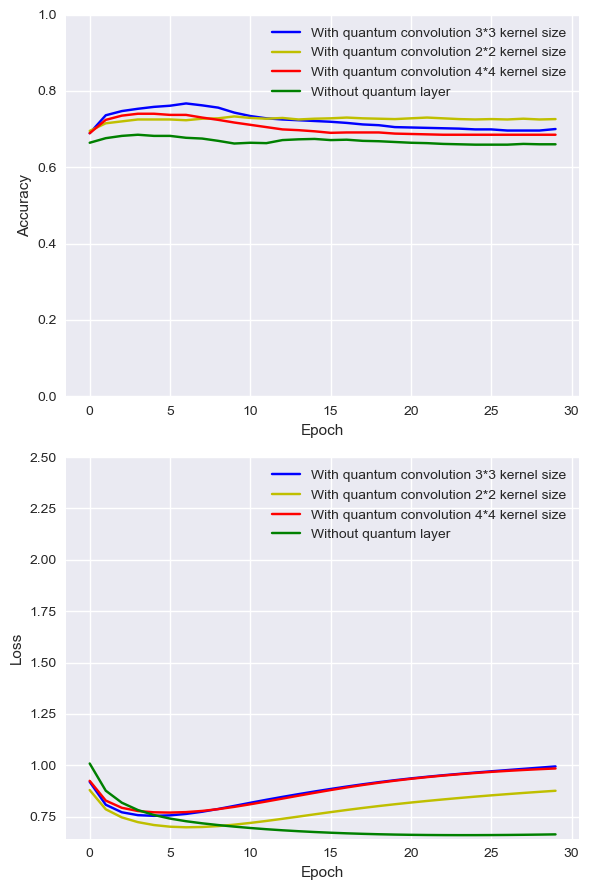

In [126]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))


ax1.plot(vaq3, "-b", label="With quantum convolution 3*3 kernel size")
ax1.plot(vaq2, "-y", label="With quantum convolution 2*2 kernel size")
ax1.plot(vaq4, "-r", label="With quantum convolution 4*4 kernel size")
ax1.plot(average_val_accuracies_c, "-g", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(valq3, "-b", label="With quantum convolution 3*3 kernel size")
ax2.plot(valq2, "-y", label="With quantum convolution 2*2 kernel size")
ax2.plot(valq4, "-r", label="With quantum convolution 4*4 kernel size")
ax2.plot(average_val_losses_c, "-g", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()